In [1]:
import rasterio
from rasterio.plot import show
# from rasterio import plot as rasterioplt
import numpy as np

from ml4floods.data.worldfloods.configs import BANDS_S2, CHANNELS_CONFIGURATIONS

# EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif    
# EMSR279_05ZARAGOZA_DEL_MONIT02_v1_observed_event_a.tif
# EMSR280_03FALUN_DEL_MONIT06_v2_observed_event_a.tif
# EMSR287_05MAGWITZ_DEL_v1_observed_event_a.tif
# RS2_20161008_Water_Extent_Corail_Pestel.tif
# ST1_20161014_WaterExtent_BinhDinh_Lake.tif
img_name = 'ST1_20161014_WaterExtent_BinhDinh_Lake.tif'
img_location = '/mnt/d/Flooding/worldfloods_v1_sample/val/'
tiff_input= img_location + 'S2/' + img_name
ground_truth= img_location + 'gt/' + img_name
# channels = 'bgri'       

## Ground Trust evaluation

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 910, 'height': 3390, 'count': 13, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 108.75489919804352,
       0.0, -8.983152841195215e-05, 14.328308444763191), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


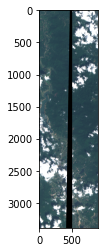

In [2]:
with rasterio.open(tiff_input, "r") as rst:
    inputs = rst.read()
    print(rst.profile) 
    band_names_current_image = [BANDS_S2[iband] for iband in CHANNELS_CONFIGURATIONS['all']]
    bands = [band_names_current_image.index(b) for b in ["B4", "B3", "B2"]]
    rgb = np.clip(inputs[bands, :, :]/3000.,0,1)
    show(rgb)

In [3]:
from matplotlib import colors
import matplotlib.patches as mpatches
def get_cmap_norm_colors(color_array, interpretation_array):
    cmap_categorical = colors.ListedColormap(color_array)
    norm_categorical = colors.Normalize(vmin=-.5,
                                        vmax=color_array.shape[0]-.5)
    patches = []
    for c, interp in zip(color_array, interpretation_array):
        patches.append(mpatches.Patch(color=c, label=interp))
    
    return cmap_categorical, norm_categorical, patches
INTERPRETATION_WORLDFLOODS = ["invalid", "land", "water", "cloud"]
COLORS_WORLDFLOODS = np.array([[0, 0, 0], # 0: invalid
                                         [139, 64, 0], # 1: land
                                         [0, 0, 139], # 2: water
                                         [220, 220, 220]], # 3: cloud
                                        dtype=np.float32) / 255
cmap_preds, norm_preds, patches_preds = get_cmap_norm_colors(COLORS_WORLDFLOODS, INTERPRETATION_WORLDFLOODS)



{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 910, 'height': 3390, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(8.983152841195215e-05, 0.0, 108.75489919804352,
       0.0, -8.983152841195215e-05, 14.328308444763191), 'tiled': False, 'interleave': 'band'}


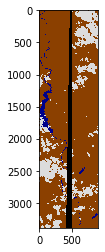

In [4]:
with rasterio.open(ground_truth, "r") as rst2:
    input_gt = rst2.read()
    print(rst2.profile) 
#     show(input_gt)
    show(input_gt, cmap=cmap_preds, norm=norm_preds, interpolation='nearest')
    

## Segmentation Prediction evaluation - RGB

In [5]:
import sys, os
from pathlib import Path
import importlib
from models import flooding_model
from ml4floods.models.config_setup import get_default_config
import torch

experiment_name = "WFV1_unet"
prod_dev = "2_PROD"

# config_fp = "train_models/training_flooding/config_rgb.json"
config_fp = "train_models/training_flooding_rgb/config_rgb_epoch_4.json"

config = get_default_config(config_fp)
config.data_params.data_params='ml4cc_data_lake'

from pytorch_lightning.utilities.cloud_io import load
from models.flooding_model import WorldFloodsModel
importlib.reload(flooding_model)

model = WorldFloodsModel(config.model_params)
# path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgb.pt").replace("\\","/")
path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgb_epoch_4.pt").replace("\\","/")

print(path_to_models)
model.load_state_dict(load(path_to_models))
model

model.eval()
model.to("cuda") # comment this line if your machine does not have GPU

# from ml4floods.models.model_setup import get_model_inference_function
from models.inference import get_model_inference_function

inference_function = get_model_inference_function(model, config, apply_normalization=True)

Loaded Config for experiment:  training_flooding_rgb
{   'data_params': {   'batch_size': 32,
                       'bucket_id': '',
                       'channel_configuration': 'rgb',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 7,
                       'path_to_splits': '/mnt/d/Flooding/worldfloods_v1_sample',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/mnt/d/Flooding/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]},
  

In [6]:
channels = [3, 2, 1]
with rasterio.open(tiff_input, "r") as rst:
    inputs = rst.read((np.array(channels) + 1).tolist())
    torch_inputs = torch.Tensor(inputs.astype(np.float32)).unsqueeze(0)
    print(torch_inputs.shape)
#     torch_target = torch.zeros_like(torch_input)
#     print(torch_target.shape)

torch.Size([1, 3, 3390, 910])


In [7]:
outputs = inference_function(torch_inputs) # (batch_size, num_classes, h, w)
predictions = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)
# +1 because value 0 is invalid
prediction_show = (predictions + 1).cpu().numpy().astype(float)

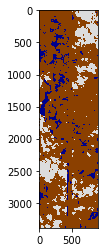

<AxesSubplot:>

In [8]:
show(prediction_show, cmap=cmap_preds, norm=norm_preds, interpolation='nearest')

## Segmentation Prediction evaluation

In [9]:
# config_fp = "train_models/training_flooding/config_rgb.json"
config_fp = "train_models/training_flooding_bgri/config_rgbnir_epoch_4.json"

config = get_default_config(config_fp)
config.data_params.data_params='ml4cc_data_lake'

from pytorch_lightning.utilities.cloud_io import load
from models.flooding_model import WorldFloodsModel
importlib.reload(flooding_model)

model = WorldFloodsModel(config.model_params)
# path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgb.pt").replace("\\","/")
path_to_models = os.path.join(config.model_params.model_folder,config.experiment_name, "model_rgbnir_epoch_4.pt").replace("\\","/")

print(path_to_models)
model.load_state_dict(load(path_to_models))
model

model.eval()
model.to("cuda") # comment this line if your machine does not have GPU

# from ml4floods.models.model_setup import get_model_inference_function
from models.inference import get_model_inference_function

inference_function = get_model_inference_function(model, config, apply_normalization=True)

Loaded Config for experiment:  training_flooding_bgri
{   'data_params': {   'batch_size': 32,
                       'bucket_id': '',
                       'channel_configuration': 'bgri',
                       'download': {'test': True, 'train': True, 'val': True},
                       'filter_windows': {   'apply': False,
                                             'threshold_clouds': 0.5,
                                             'version': 'v1'},
                       'input_folder': 'S2',
                       'loader_type': 'local',
                       'num_workers': 4,
                       'path_to_splits': '/mnt/d/Flooding/worldfloods_v1_sample',
                       'target_folder': 'gt',
                       'test_transformation': {'normalize': True},
                       'train_test_split_file': '/mnt/d/Flooding/train_test_split.json',
                       'train_transformation': {'normalize': True},
                       'window_size': [256, 256]},


In [10]:
channels = [1, 2, 3, 7]
with rasterio.open(tiff_input, "r") as rst:
    inputs = rst.read((np.array(channels) + 1).tolist())
    torch_inputs = torch.Tensor(inputs.astype(np.float32)).unsqueeze(0)
    print(torch_inputs.shape)
#     torch_target = torch.zeros_like(torch_input)
#     print(torch_target.shape)

torch.Size([1, 4, 3390, 910])


In [11]:
outputs = inference_function(torch_inputs) # (batch_size, num_classes, h, w)
predictions = torch.argmax(outputs, dim=1).long() # (batch_size, h, w)
# +1 because value 0 is invalid
prediction_show = (predictions + 1).cpu().numpy().astype(float)

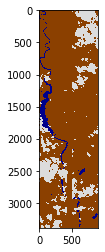

<AxesSubplot:>

In [12]:
show(prediction_show, cmap=cmap_preds, norm=norm_preds, interpolation='nearest')